# libs

In [ ]:
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np 
import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import (r2_score, mean_squared_error)
from statsmodels.graphics import gofplots as sm

# Входные данные

In [3]:
df = pd.read_excel('2021-03-09.xlsx')

<h1><center>FILE</center></h1>


| Название поля | Описание |
| --- | :--- |
| StudentID | id студента |
| LabInsctructorID | id преподавателя, который ведет лабы |
| PracticeInsctructorID | id преподавателя, который ведет практику |
| LectureInsctructorID | id преподавателя, который ведет лекции (очень важное поле на мой взгляд) |
| CourseID | id курса |
| PrerequisiteCourseID | id курса, который является пререквизитом. |
| CourseCreditsNum | кол-во кредитов курса |
| StudyYear | год обучения |
| SemesterTypeID | 1,2,3 (осень, весна, лето) |
| LanguageID | язык курса |
| Attestation1 | балл за 1 аттестацию |
| Attestation2 | балл за 2 аттестацию |
| Final | балл за финальный экзамен |
| TotalPoints | общий балл за семестр по курсу |
| LetterGrade | буквенное значение оценки по курсу |
| Coefficient | значение коэфициента (A = 4.0, A- = 3.66 ...) |
| SemesterGPA | GPA за семестр | 
| YearGPA | годовой GPA |
| CumulativeGPA | кумулятивный GPA (общий) |
| SpecialityID | ID специальности, захешированный |
| Year |  год обучения, но с этим могут быть неточности [1-4 Бакалавр 5-6 магистр 7-10 phd] |
| CourseTypeID | тип курса |
| CourseTypeDVOID | типы дополнительного вида обучения |

# Типы данных

In [24]:
len(df.columns)
df.dtypes

StudentID                  object
SpecialityID               object
Region                     object
District                   object
SchoolType                 object
School                     object
LabInsctructorID          float64
PracticeInsctructorID     float64
LectureInsctructorID      float64
CourseID                   object
CourseCode                 object
PrerequisiteCourseID       object
PrerequisiteCourseCode     object
CourseTypeID               object
CourseTypeDVOID           float64
CourseCreditsNum           object
StudyYear                 float64
SemesterTypeID            float64
LanguageID                float64
Attestation1              float64
Attestation2              float64
Final                     float64
TotalPoints               float64
LetterGrade                object
Coefficient               float64
SemesterGPA               float64
YearGPA                   float64
CumulativeGPA             float64
Year                      float64
dtype: object

# Проблема пропущенных значений

<AxesSubplot:>

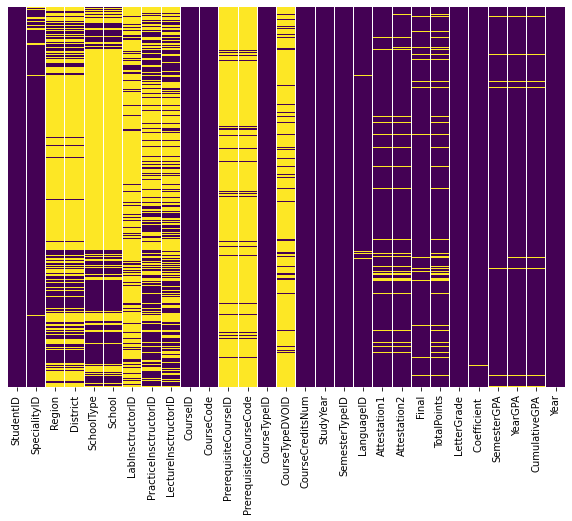

In [25]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False,cmap='viridis')

<AxesSubplot:>

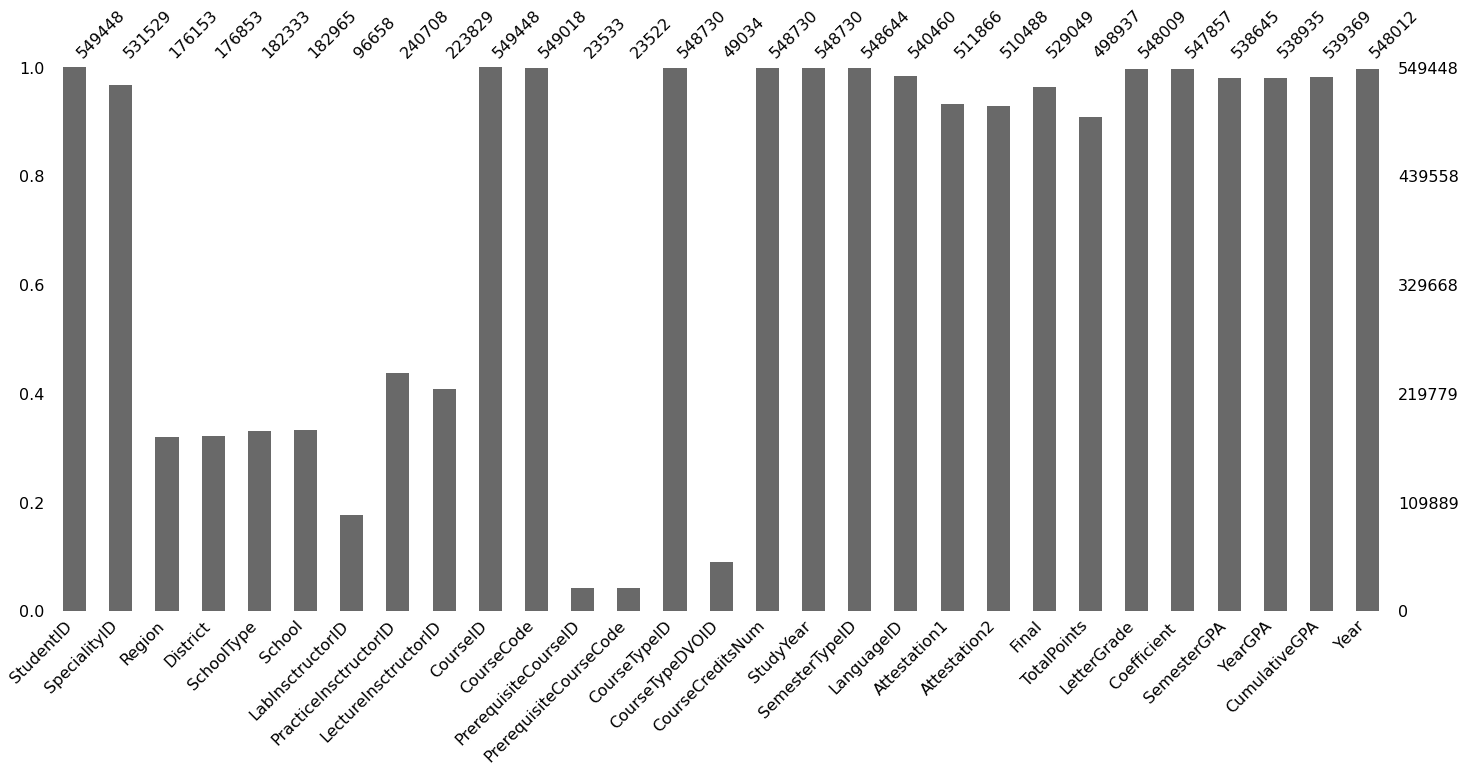

In [26]:
msno.bar(df)

# Количество студентов

In [27]:
len(df.StudentID.unique())

16648

# Проверка на нормальность распределения

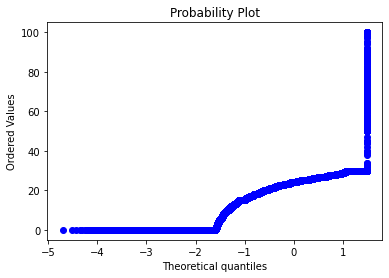

In [28]:
measurements = df.Attestation1.values   
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()

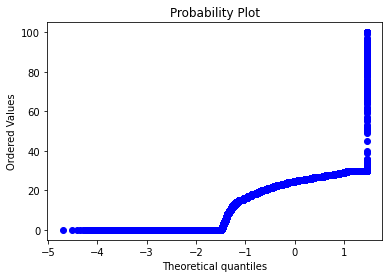

In [29]:
measurements = df.Attestation2.values   
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()

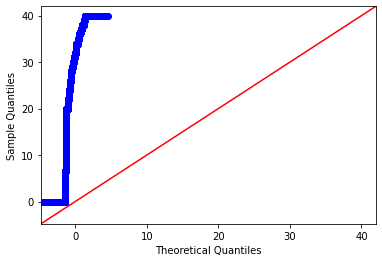

In [30]:
test = df[(df.Final>=0) & (df.Final<=40)].Final.values

sm.qqplot(test, line='45')
pylab.show()

# Корреляция

In [31]:
test = df[['CourseCreditsNum','Attestation1','Attestation2','Final','TotalPoints',
    'LetterGrade', 'Coefficient ', 'SemesterGPA', 'YearGPA',
       'CumulativeGPA', 'Year']]

Text(0.5, 1.0, 'Corelation Matrix')

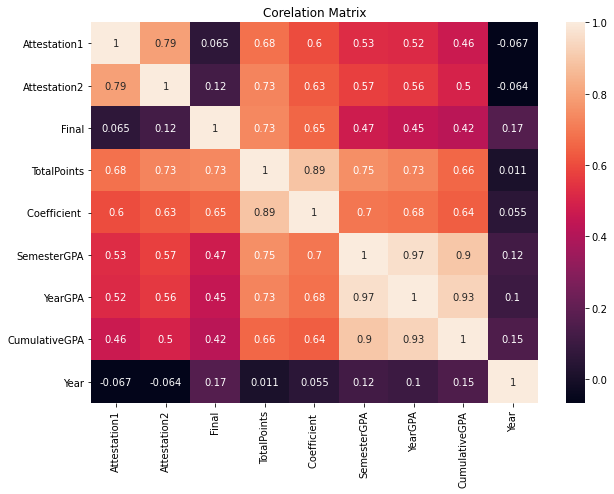

In [32]:
plt.figure(figsize=(10,7))
sns.heatmap(test.corr(), annot=True)
plt.title('Corelation Matrix')


# Предварительный отбор признаков

<Figure size 720x504 with 0 Axes>

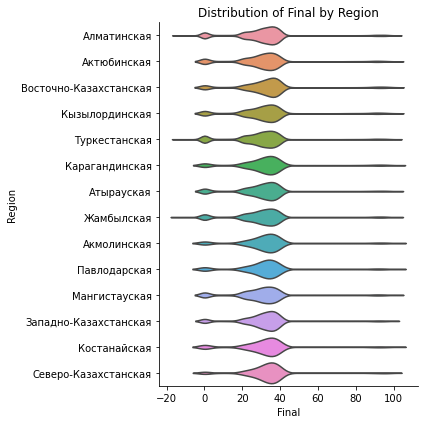

In [33]:
plt.figure(figsize=(10,7))

sns.catplot(x="Final", y="Region", kind="violin", inner=None,
            data=df, height = 6,order = ['Алматинская', 'Актюбинская', 'Восточно-Казахстанская',
       'Кызылординская', 'Туркестанская', 'Карагандинская', 'Атырауская',
       'Жамбылская', 'Акмолинская', 'Павлодарская', 'Мангистауская',
       'Западно-Казахстанская', 'Костанайская',
       'Северо-Казахстанская'])

plt.title('Distribution of Final by Region')
plt.tight_layout()

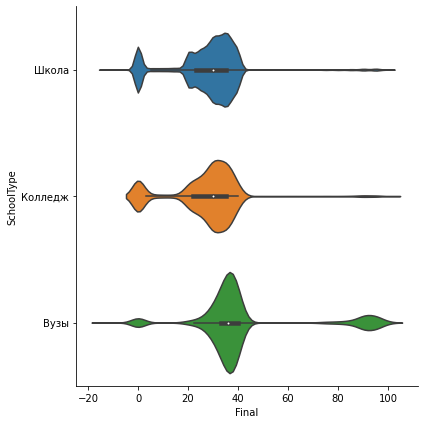

In [34]:
sns.catplot(x="Final", y="SchoolType", kind="violin", data=df, height = 6, order= ['Школа','Колледж','Вузы'])

plt.tight_layout()

# Ошибки и неточности в данных

In [35]:
for col in df.columns:
    if len(df[col].unique())<200:
        print(col)
        print()
        print(df[col].unique())
        print()
        print('****************************************')

Region

[nan 'Алматинская' 'Актюбинская' 'Восточно-Казахстанская' 'Кызылординская'
 'Туркестанская' 'Карагандинская' 'Атырауская' 'Жамбылская' 'Акмолинская'
 'Павлодарская' 'Мангистауская' 'Западно-Казахстанская' 'Костанайская'
 'MAT1011' 'Северо-Казахстанская' 'MAT1012' 'Him I 2.2.13' 'HYD1621'
 'Fiz II 2.2.11' 'VSNS' 'EAI3221.1' 'EiUP4306' 'TSV' 'KIVR' 'Mat1103']

****************************************
District

[nan 'г. Капшагай' 'Енбекшиказахский' 'Хромтауский' 'г. Семей' 'Аягозский'
 'г. Кызылорда' 'г. Шымкент' 'г. Усть-Каменогорск' 'г. Жезказган'
 'г. Атырау' 'Меркенский ' 'г. Талдыкорган' 'Талгарский' 3
 'Курмангазинский' 'г. Актобе' 'г. Кокшетау' 'г. Тараз' 'г. Экибастуз'
 'Байдибекский' 'г. Степногорск' 'Карасайский' 'Аксуский' 'г. Караганда'
 'г. Арысь' 'Мактааральский' 'Сырдарьинский' 'г. Актау' 'г. Уральск'
 'Илийский' 'Шиелийский' 'Урджарский' 'г. Жанаозен' 'Таласский '
 'г. Павлодар' 'Панфиловский' 'Жылыойский' 'Саркандский' 'г. Рудный'
 'Каратальский' 'Бейнеуский' 'Сар

<AxesSubplot:>

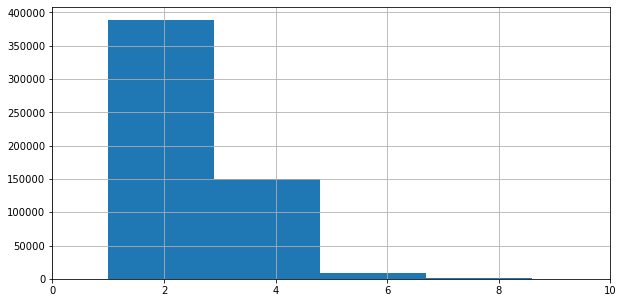

In [36]:
plt.xlim(0,10)
df.Year.hist(figsize=(10,5))

# Выбросы

Text(0.5, 1.0, 'Final boxplot')

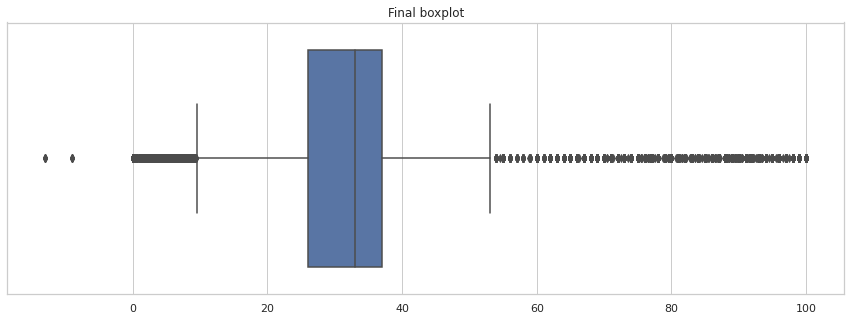

In [37]:
plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
tips = df.Final.values
ax = sns.boxplot(x=tips)
plt.title('Final boxplot')

# создаем таргет

In [38]:
df['target_object'] = df['StudentID'].astype(str) +'_'+df['CourseCode'].astype(str)

In [39]:
len(df['target_object'].unique()), len(df['StudentID'].unique()), len(df['CourseCode'].unique())

(496705, 16648, 12731)

# data leakage

In [40]:
test = df.StudyYear.value_counts().reset_index()
normal_years = test[test['index']>100]['index'].values

In [41]:
df.shape, df[df.StudyYear.isin(normal_years)].shape

((549448, 30), (548012, 30))

In [42]:
df = df[df.StudyYear.isin(normal_years)]

Text(0.5, 1.0, 'Сколько уникальных лет учились студенты')

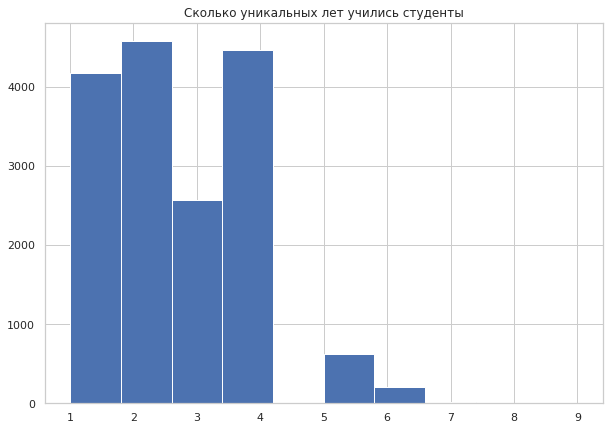

In [43]:
test = df.StudentID.value_counts().reset_index()
test = df.groupby('StudentID')['StudyYear'].nunique().reset_index()
plt.figure(figsize=(10,7))
test.StudyYear.hist()
plt.title('Сколько уникальных лет учились студенты')

# Сбор датасета

# удаляем ненужные колонки

In [44]:
new_df = df.drop(['CumulativeGPA','PrerequisiteCourseID',
                  'PrerequisiteCourseCode','Coefficient ',
                  'LetterGrade','SemesterGPA','YearGPA','CumulativeGPA',
                  'District', 'SemesterTypeID', 'CourseTypeDVOID','CourseID','Year',
                  'LabInsctructorID','PracticeInsctructorID'], axis=1)

# удаляем данные с пустыми аттестациями

In [45]:
new_df = new_df.dropna(subset=['Attestation1','Attestation2'])

# убираем неккоректные значения в оценках для каждого типа

In [46]:
new_df = new_df[(new_df.Attestation2<=30) & (new_df.Attestation2>=0)]
new_df = new_df[(new_df.Attestation1<=30) & (new_df.Attestation1>=0)]
new_df = new_df[(new_df.TotalPoints<=100) & (new_df.TotalPoints>=0)]
new_df = new_df[(new_df.Final<=40) & (new_df.Final>=0)]

# убираем дубликаты в таргете

In [47]:
new_df = new_df.drop_duplicates(subset=['target_object'])

# для обучения берем данные  по каждому студенту только за последний год + предпоследний , удаляем студентов у которых обучение было всего 1 год(или 2), потому что нам нужны аггрегации 

In [48]:
last_years = new_df.groupby('StudentID')['StudyYear'].max().reset_index()
last_years.columns = ['StudentID','last_StudyYear']
years_count = new_df.groupby('StudentID')['StudyYear'].nunique().reset_index()
years_count.columns = ['StudentID','count_StudyYear']
new_df = new_df.merge(last_years, on=['StudentID'], how='left')
new_df = new_df.merge(years_count, on=['StudentID'], how='left')
new_df['pre_last_StudyYear'] = new_df['last_StudyYear'] - 1
data = new_df[((new_df.StudyYear==new_df.last_StudyYear) | (new_df.StudyYear==new_df.pre_last_StudyYear)) & (new_df.count_StudyYear!=1) & (new_df.count_StudyYear!=2)]

# остальные данные используем для создания признаков

In [49]:
aggs_df = new_df[(new_df.StudyYear!=new_df.last_StudyYear) & (new_df.StudyYear!=new_df.pre_last_StudyYear)]

In [50]:
aggs_df[['StudyYear','CourseCode','CourseCreditsNum','Attestation1','Attestation2']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189926 entries, 0 to 441250
Data columns (total 5 columns):
StudyYear           189926 non-null float64
CourseCode          189882 non-null object
CourseCreditsNum    189926 non-null object
Attestation1        189926 non-null float64
Attestation2        189926 non-null float64
dtypes: float64(3), object(2)
memory usage: 8.7+ MB


# создаем аггрегации для каждого студента

In [51]:
student_features = aggs_df.groupby('StudentID').agg({            'StudyYear': ['nunique'],
                                              'CourseCode' : ['nunique'],
                                          'Attestation1' : ['min', 'max', 'mean', 'std', 'sum', 'last', 'first'],
                                          'Attestation2' : ['min', 'max', 'mean', 'std', 'sum', 'last', 'first'],
                                            'Final' : ['min', 'max', 'mean', 'std', 'sum', 'last', 'first'],
                                     'TotalPoints' : ['min', 'max', 'mean', 'std', 'sum', 'last', 'first']})

In [52]:
def flatten_multi_index(df,white_list, word):
    mi = df.columns
    suffixes, prefixes = mi.levels
    print(white_list)
    col_names = [word+prefixes[i_p] + '_' + suffixes[i_s] for (i_s, i_p) in zip(*mi.codes) if suffixes[i_s] not in white_list]
    df.columns = white_list + col_names
    return 0

In [53]:
flatten_multi_index(student_features,[],'student_')

[]


0

# создаем аггрегации для каждого лектора, гипотеза в том что лектор напрямую влияет на оценку

In [54]:
lector_features = aggs_df.groupby('LectureInsctructorID').agg({
                                          'Attestation1' : ['min', 'max', 'mean', 'std', 'sum', 'last', 'first'],
                                          'Attestation2' : ['min', 'max', 'mean', 'std', 'sum', 'last', 'first'],
                                            'Final' : ['min', 'max', 'mean', 'std', 'sum', 'last', 'first'],
                                     'TotalPoints' : ['min', 'max', 'mean', 'std', 'sum', 'last', 'first']})

In [55]:
flatten_multi_index(lector_features,[],'lector_')

[]


0

In [56]:
lector_features.reset_index(inplace=True)
student_features.reset_index(inplace=True)

# рассчитываем дельты между годами на уровне студентов и тоталов,  чтобы модель могла видеть тренд изменения оценок

In [57]:
delta = aggs_df.groupby(['StudentID','StudyYear'])['TotalPoints'].sum()
delta = delta.reset_index()
delta = delta.pivot_table(values='TotalPoints',index='StudentID',columns='StudyYear')
delta = delta.fillna(0)
diffmean=list()
for i in delta.values:
    temp=list()
    for j in range(len(i)-1):
        temp.append(i[j+1]-i[j])
    diffmean.append(np.mean(temp))

delta['delta_total_by_years']  = diffmean

delta = delta.reset_index()

delta = delta[['StudentID','delta_total_by_years']]